In [99]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quaternion
import sympy
from sympy.abc import x,y,z
from sympy.utilities.codegen import codegen

In [100]:
# path = "../data/tst_cal_005.csv"
# path = "../test/tst_data/data5_tst_cal_004_onArmArbitraryMotions.csv"
# path = "../test/tst_data/data6_tst_cal_004_onArmArbitraryMotions.csv"
path = "../test/tst_data/data7_tst_cal_004_onArmArbitraryMotions.csv"
df = pd.read_csv(path)

# df.head(0)

class Observation:
    def __init__(self,omega1,omega2,q1,q2) -> None:
        self.qR     = q1.conj() * q2
        self.omegaR = quaternion.rotate_vectors(self.qR,omega2) - omega1

obs = []
obs_num = df.shape[0]

for i,row in df.iterrows():
    ## Retrieve data from csv file
    omega1 = np.array([ row['IMU_GYROSCOPE(0)_0'], row['IMU_GYROSCOPE(0)_1'], row['IMU_GYROSCOPE(0)_2']] )
    omega2 = np.array([ row['IMU_GYROSCOPE(1)_0'], row['IMU_GYROSCOPE(1)_1'], row['IMU_GYROSCOPE(1)_2']] )
    q1 = np.quaternion(row['IMU_QUATERNION(0)_0'], row['IMU_QUATERNION(0)_1'], row['IMU_QUATERNION(0)_2'], row['IMU_QUATERNION(0)_3'])
    q2 = np.quaternion(row['IMU_QUATERNION(1)_0'], row['IMU_QUATERNION(1)_1'], row['IMU_QUATERNION(1)_2'], row['IMU_QUATERNION(1)_3'])
    ## Add observation to buffer
    obs.append(Observation(omega1,omega2,q1,q2))

## Define equations

In [101]:
theta1,rho1,theta2,rho2 = sympy.symbols('theta_1 rho_1 theta_2 rho_2')
j1 = sympy.Matrix([
        sympy.sin(theta1)*sympy.cos(rho1),
        sympy.sin(theta1)*sympy.sin(rho1),
        sympy.cos(theta1)
    ])
j2 = sympy.Matrix([
        sympy.sin(theta2)*sympy.cos(rho2),
        sympy.sin(theta2)*sympy.sin(rho2),
        sympy.cos(theta2)
    ])
omegaX,omegaY,omegaZ = sympy.symbols('omega_x omega_y omega_z')
omegaR = sympy.Matrix([omegaX, omegaY, omegaZ ])

jn = j1.cross(j2)
jn_norm = jn/(sympy.sqrt(jn.dot(jn)))
error_exp = omegaR.dot(jn_norm)
error_exp = sympy.simplify(error_exp)
error_exp

(omega_x*(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1)) - omega_y*(sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1)) - omega_z*sin(theta_1)*sin(theta_2)*sin(rho_1 - rho_2))/sqrt((sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1))**2 + (sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1))**2 + sin(theta_1)**2*sin(theta_2)**2*sin(rho_1 - rho_2)**2)

In [102]:
derr_theta1_exp = sympy.simplify(sympy.diff(error_exp,theta1))
derr_rho1_exp   = sympy.simplify(sympy.diff(error_exp,rho1))
derr_theta2_exp = sympy.simplify(sympy.diff(error_exp,theta2))
derr_rho2_exp   = sympy.simplify(sympy.diff(error_exp,rho2))

J_col_exp = sympy.Matrix(4,1, [
    derr_theta1_exp, derr_rho1_exp, derr_theta2_exp, derr_rho2_exp
])
J_col_exp

Matrix([
[  ((-omega_x*(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1)) + omega_y*(sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1)) + omega_z*sin(theta_1)*sin(theta_2)*sin(rho_1 - rho_2))*(4*sin(2*theta_1) + 6*sin(2*theta_1 - 2*theta_2) + 6*sin(2*theta_1 + 2*theta_2) - 2*sin(-2*rho_1 + 2*rho_2 + 2*theta_1) - 2*sin(2*rho_1 - 2*rho_2 + 2*theta_1) + sin(-2*rho_1 + 2*rho_2 + 2*theta_1 + 2*theta_2) - 4*sin(-rho_1 + rho_2 + 2*theta_1 + 2*theta_2) - 4*sin(rho_1 - rho_2 - 2*theta_1 + 2*theta_2) + 4*sin(rho_1 - rho_2 + 2*theta_1 - 2*theta_2) - 4*sin(rho_1 - rho_2 + 2*theta_1 + 2*theta_2) - sin(2*rho_1 - 2*rho_2 - 2*theta_1 + 2*theta_2) + sin(2*rho_1 - 2*rho_2 + 2*theta_1 - 2*theta_2) + sin(2*rho_1 - 2*rho_2 + 2*theta_1 + 2*theta_2))/32 + (omega_x*(sin(rho_1)*cos(theta_1)*cos(theta_2) + sin(rho_2)*sin(theta_1)*sin(theta_2)) - omega_y*(sin(theta_1)*sin(theta_2)*cos(rho_2) + cos(rho_1)*cos(theta_1)*cos(theta_2)) - omega_z*sin(theta_2)*sin(rh

### Compute lambda functions to be used by the algorithm

In [103]:
# Sympy symbols to be used as arguments of lambdas
vars = [theta1,rho1,theta2,rho2,omegaX,omegaY,omegaZ]
# Error lambda
error = sympy.lambdify(vars, error_exp)
# Error partials of each spherical coord. lambda
J_col = sympy.lambdify(vars, J_col_exp)
# Rotation vector lambda
j_compute = sympy.lambdify([theta1,rho1], j1)

## Agorithm

In [104]:
WINDOW_SIZE = 500
ITERATIONS = 100

In [160]:

Jacobian     = np.zeros((WINDOW_SIZE,4))
error_vector = np.zeros((WINDOW_SIZE,1))

rand_ang = lambda: np.pi - 2*np.pi*np.random.random()
phi = np.array([
    [rand_ang()],
    [rand_ang()],
    [rand_ang()],
    [rand_ang()]
    ])

j = WINDOW_SIZE
ev = []
while j < obs_num:
    for iteration in range(ITERATIONS):
        sqr_e = 0
        for i in range(WINDOW_SIZE):
            ## Calculate error
            e = error(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
            sqr_e = sqr_e + e**2
            ## Calculate jacobian
            de = J_col(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
            ## Build error vector
            error_vector[i] = e
            ## Build jacobian
            Jacobian[i] = np.transpose(de)

        ev.append(np.sqrt(sqr_e/WINDOW_SIZE))
        if 4 < iteration and np.abs(ev[-2] - ev[-1]) < 1e-1: break
        phi -= np.matmul( np.linalg.pinv(Jacobian), error_vector )

    j += WINDOW_SIZE

phi

array([[ 0.55507086],
       [ 1.24184272],
       [-2.20697873],
       [ 0.55970637]])

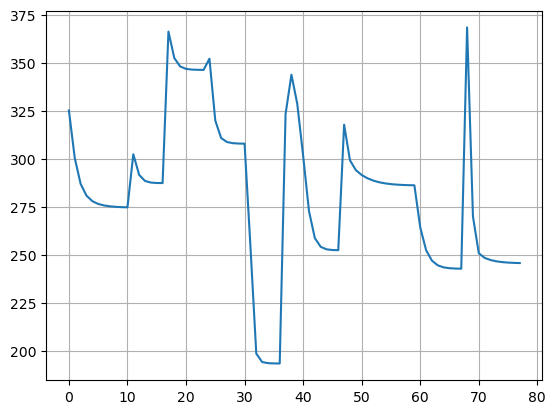

In [161]:
from matplotlib import pyplot as plt
plt.grid(True)
plt.plot(ev)

In [162]:
j_compute(phi[0],phi[1])

array([[[0.17025003]],

       [[0.49874607]],

       [[0.8498631 ]]])

In [163]:
j_compute(phi[2],phi[3])

array([[[-0.68163182]],

       [[-0.42706999]],

       [[-0.59412902]]])

In [164]:
print(f"check for singularities: {np.sin(phi[0])} and {np.sin(phi[2])}")

check for singularities: [0.52700352] and [-0.80436976]
